In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': 'https://drive.google.com/file/d/1JLSdtn-9hjtLDoM0mP6gBs66ELW5I3Ta/view?usp=sharing',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': 'https://drive.google.com/file/d/1yuuebSSRxrsjtsONOkL470t2OG2arfUC/view?usp=sharing',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': 'https://drive.google.com/file/d/1ZMXvZ-syUJ4eZWhzQi2z-eaIG8_5IcXA/view?usp=sharing'
}

# EVALUATE_ONLY = True
# TEST_ON_LARGE_DATASET = True
# TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
# DATASETS_LINKS = {
#     'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
#     'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
#     'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
#     'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
#     'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
#     'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
# }

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import v2
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False

        url = f"{DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(output=output, url=url, fuzzy=True)

        # url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        # output = f'{name}.npz'
        # gdown.download(output=output, url=url,quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

In [6]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

In [7]:
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray

train = Dataset("train")
test = Dataset("test")

Downloading...
From (original): https://drive.google.com/uc?id=1JLSdtn-9hjtLDoM0mP6gBs66ELW5I3Ta
From (redirected): https://drive.google.com/uc?id=1JLSdtn-9hjtLDoM0mP6gBs66ELW5I3Ta&confirm=t&uuid=018d6d7b-04ef-4d85-9e54-0551f1c71849
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:24<00:00, 85.6MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From (original): https://drive.google.com/uc?id=1yuuebSSRxrsjtsONOkL470t2OG2arfUC
From (redirected): https://drive.google.com/uc?id=1yuuebSSRxrsjtsONOkL470t2OG2arfUC&confirm=t&uuid=13a04acf-3dac-429c-9653-61d413f4cde3
To: /content/test.npz
100%|██████████| 525M/525M [00:08<00:00, 59.0MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [11]:
class Model:

    def __init__(self):
        self.net = torchvision.models.resnet50(weights='DEFAULT').to(device)
        self.net.fc = nn.Linear(self.net.fc.in_features, 9)
        self.net = self.net.to(device)

        self.transforms = v2.Compose([
            v2.ToImage(),
            v2.Resize((128, 128)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.74155, 0.53792, 0.70838], [0.16481, 0.21839, 0.15796])
        ])

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=0.001, weight_decay=0.001)

    def save(self, name: str):
        torch.save(self.net.state_dict(), f'/content/drive/MyDrive/{name}.pt')

    def load(self, name: str):
        name_to_id_dict = {
            'best': 'https://drive.google.com/file/d/1Y5b7dWOZwQ63GzJcOQYK91KsYmVTxiSn/view?usp=sharing'
        }
        output = f'{name}.pt'
        gdown.download(name_to_id_dict[name], output, fuzzy=True)
        self.net.load_state_dict(torch.load(output))
        self.net = self.net.to(device)
        self.net.eval()
        print(f"Model {name} loaded")

    def train_epoch(self, train_loader):
        self.net.train()
        r_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            self.optimizer.zero_grad()
            x = []
            for i in range(data.shape[0]):
                img = self.transforms(data[i])
                x.append(img)

            x = torch.tensor(np.array(x))
            x = x.to(device)

            target = target.to(device)
            outputs = self.net(x)
            loss = self.criterion(outputs, target)
            r_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            if batch_idx % 50 == 49:
                print("batch ", batch_idx + 1, ": ", loss)
        r_loss /= len(train_loader)

        return r_loss

    def train(self, dataset: Dataset):
        print(f'training started')

        levels = 8
        BATCH_SIZE = 64

        X_train = torch.tensor(dataset.images).permute(0, 3, 1, 2)
        y_train = torch.tensor(dataset.labels)

        train_data = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)

        num_epochs = 25

        x = np.linspace(0, num_epochs, num_epochs)
        y = np.zeros(num_epochs)
        for i in range(num_epochs):
            print("epoch", i + 1, ":")
            y[i] = self.train_epoch(train_loader)

        fig, ax = plt.subplots(figsize=(10,4))

        ax.plot(x, np.array(y))
        plt.title("Loss by epoch")
        plt.show()

        sleep(2)
        print(f'training done')
        pass

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        self.net.eval()
        resh_img = img.reshape(3, img.shape[0], img.shape[1])
        x = torch.tensor(np.array([self.transforms(img)])).to(device)
        outputs = self.net(x)

        prediction = torch.max(outputs, 1).indices.item()
        return prediction

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


training started
epoch 1 :
batch  50 :  tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  100 :  tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  150 :  tensor(0.1379, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  200 :  tensor(0.1900, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  250 :  tensor(0.1982, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 2 :
batch  50 :  tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  100 :  tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  150 :  tensor(0.1085, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  200 :  tensor(0.4834, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  250 :  tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 3 :
batch  50 :  tensor(0.1528, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  100 :  tensor(0.1672, device='cuda:0', grad_fn=<NllLossBackward0>)
batch  150 :  tensor(0.0386, device='cuda:0', grad_fn=<NllLossBackwa

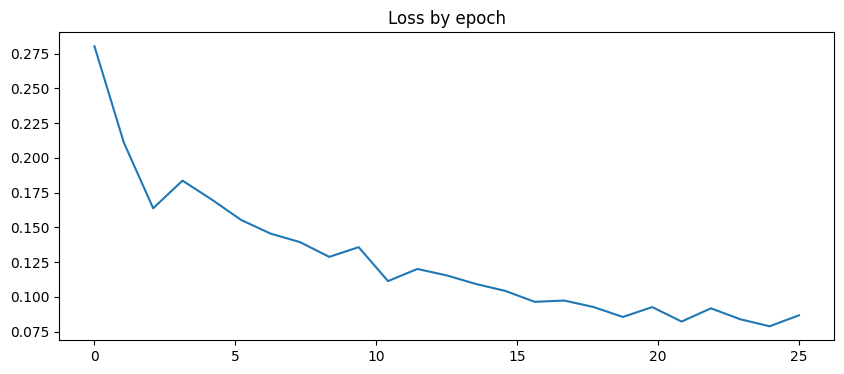

training done


In [9]:
model = Model()

if not EVALUATE_ONLY:
    model.train(train)
    model.save('best')
else:
    model.load('best')

In [10]:
pred = model.test_on_dataset(test)
Metrics.print_all(test.labels, pred, info = "test dataset")

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test dataset:
	 accuracy 0.9642:
	 balanced accuracy 0.9642:


In [14]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred_2 = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred_2, 'test-tiny')

Downloading...
From (original): https://drive.google.com/uc?id=1Y5b7dWOZwQ63GzJcOQYK91KsYmVTxiSn
From (redirected): https://drive.google.com/uc?id=1Y5b7dWOZwQ63GzJcOQYK91KsYmVTxiSn&confirm=t&uuid=a481aec7-adaf-49b6-818f-2b86bf139979
To: /content/best.pt
100%|██████████| 94.4M/94.4M [00:00<00:00, 122MB/s]
<ipython-input-11-c5da5f55341a>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glo

Model best loaded


Downloading...
From: https://drive.google.com/uc?id=1ZMXvZ-syUJ4eZWhzQi2z-eaIG8_5IcXA
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 27.4MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9000:
	 balanced accuracy 0.9000:
